In [57]:
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
df = pd.read_json('data/jsondata/alarm clock.ndjson', lines=True)


In [30]:
ndjson_line = df.iloc[22]
ndjson_line

word                                                 alarm clock
countrycode                                                   RU
timestamp                       2017-01-27 18:31:28.932770+00:00
recognized                                                  True
key_id                                          5629675671912448
drawing        [[[183, 171, 149, 134, 105, 81, 64, 50, 35, 30...
Name: 22, dtype: object

In [31]:
def line(x0, y0, x1, y1):
    "Bresenham's line algorithm"
    points_in_line = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points_in_line.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points_in_line.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points_in_line.append((x, y))
    return points_in_line

In [32]:
import numpy as np
ink_array = ndjson_line['drawing']
stroke_lengths = [len(stroke[0]) for stroke in ink_array]
total_points = sum(stroke_lengths)
np_ink = np.zeros((total_points,3),dtype=np.int16)
current_t = 0
for stroke in ink_array:
    for i in [0, 1]:
        np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
    current_t += len(stroke[0])
    np_ink[current_t - 1, 2] = 1 
lower = np.min(np_ink[:, 0:2], axis = 0)
upper = np.max(np_ink[:, 0:2], axis = 0)
scale = upper-lower+1
scale[scale==0]=1

In [33]:
np_image = np.zeros((upper/8+1).astype(int),dtype=np.float32)
for idx, stroke in enumerate(ink_array):
    for i in range(stroke_lengths[idx]-1):
        # np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
        x1=int(stroke[0][i]/8)
        y1=int(stroke[1][i]/8)
        x2 = int(stroke[0][i+1]/8)
        y2 = int(stroke[1][i+1]/8)
        points_between = line(x1,y1,x2,y2)
        for p in points_between:
            np_image[p] = 1

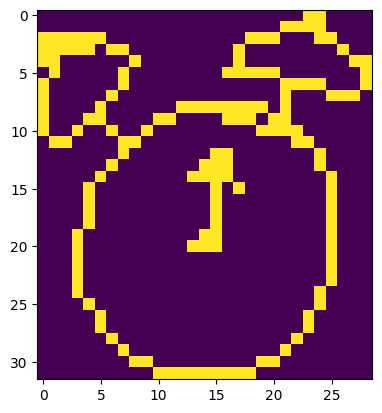

In [34]:
import matplotlib.pyplot as plt
plt.imshow(np_image.T)

In [35]:
np_image.shape

(29, 32)

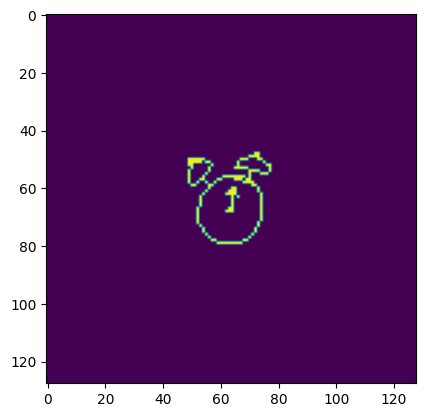

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.CenterCrop((128,128)),
    transforms.Resize((128,128))
     ])
plt.imshow(transform(np_image)[0].T)

In [37]:
from datasets import Dataset
train_ds = Dataset.from_pandas(df)

train_ds = train_ds.select(range(2000))

In [38]:
# def convert_to_features(examples):
#     label = examples['word']
#     ink_array = examples['drawing']
#     stroke_lengths = [len(stroke[0]) for stroke in ink_array]
#     np_image = np.zeros((256,256),dtype=np.float32)
#     for idx, stroke in enumerate(ink_array):
#         for i in range(stroke_lengths[idx]-1):
#             # np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
#             x1=stroke[0][i]
#             y1=stroke[1][i]
#             x2 = stroke[0][i+1]
#             y2 = stroke[1][i+1]
#             points_between = line(x1,y1,x2,y2)
#             for p in points_between:
#                 np_image[p] = 1
#     return {'label':label, 'features':np_image}
# train_ds = train_ds.map(convert_to_features, batched= False, num_proc= 10 )

In [39]:
# train_ds = train_ds.remove_columns(['countrycode','timestamp','recognized','key_id','drawing','word'])

In [40]:
from torch.utils.data import Dataset
import subprocess,os
import pickle
from tqdm import tqdm
import pandas as pd
DATA_DIR = 'data'
class QuickDraw(Dataset):
    def __init__(self, root, transform, mode='all', sample = 20, download = False):
        print(f"Init Dataset for {mode}-{sample} mode")
        self.root = root
        self.transform = transform
        self.sample = sample
        self.mode = mode
        self._bookkeeping_path = os.path.join(self.root, DATA_DIR,'bookkeeping' ,'quickdraw-' + mode+'-'+str(sample)+ '-bookkeeping.pkl')
        self.data_path = os.path.join(self.root, DATA_DIR, 'jsondata')
        dir_list = os.listdir(self.data_path)
        if mode == "debuging":
            dir_list=dir_list[:20]
        elif mode == "train":
            dir_list=dir_list[:int(len(dir_list)*0.6)]
        elif mode == "validation":
            dir_list=dir_list[int(len(dir_list)*0.6):int(len(dir_list)*0.8)]
        elif mode == "test":
            dir_list=dir_list[int(len(dir_list)*0.8):]
        self.splits = list(map(lambda x: os.path.splitext(x)[0],dir_list))
        if not self._check_exists() and download:
            self.download()
        self.load_bookkeeping()
        self.load_data()

    def _check_exists(self):
        if not os.path.exists(self.root):
            return False
        if not os.path.exists(self.data_path):
            return False
        return True

    def download(self):
        if not os.path.exists(self.data_path):
            os.mkdir(self.data_path)
        print('Downloading Quickdraw dataset (25Gb)')
        cmd = ['gsutil', '-m', 'cp','gs://quickdraw_dataset/full/simplified/*.ndjson',self.data_path]
        subprocess.call(cmd)

    def load_bookkeeping(self):
        if not os.path.exists(self._bookkeeping_path):
            # create bookkeeping
            labels = list(range(len(self.splits)))
            indices_to_labels = {}
            labels_to_indices = {}
            offsets = []
            index_counter = 0
            for cls_idx, cls_name in enumerate(self.splits):
                if self.sample == 'all':
                    cls_path = os.path.join(self.data_path, cls_name + '.ndjson')
                    cls_data = pd.read_json(cls_path, lines=True)
                    num_samples = cls_data.shape[0]
                else:
                    num_samples = self.sample
                labels_to_indices[cls_idx] = list(range(index_counter, index_counter + num_samples))
                for i in range(num_samples):
                    indices_to_labels[index_counter + i] = cls_idx
                offsets.append(index_counter)
                index_counter += num_samples
            bookkeeping = {
                'labels_to_indices': labels_to_indices,
                'indices_to_labels': indices_to_labels,
                'labels': labels,
                'offsets': offsets,
            }
            # Save bookkeeping to disk
            with open(self._bookkeeping_path, 'wb') as f:
                pickle.dump(bookkeeping, f, protocol=-1)
        else:
            with open(self._bookkeeping_path, 'rb') as f:
                bookkeeping = pickle.load(f)
        self._bookkeeping = bookkeeping
        self.labels_to_indices = bookkeeping['labels_to_indices']
        self.indices_to_labels = bookkeeping['indices_to_labels']
        self.labels = bookkeeping['labels']
        self.offsets = bookkeeping['offsets']

    def load_data(self):
        self.data = []
        # load cache if exist
        cache_path = f'data/data_sample/{self.mode}-{self.sample}.pkl'
        if not os.path.exists(cache_path):
            bar = tqdm(enumerate(self.splits), total=len(self.splits))
            for i,cls_name in bar:
                bar.set_postfix(data_path = cls_name)
                cls_path = os.path.join(self.data_path, cls_name + '.ndjson')
                data_df = pd.read_json(cls_path, lines=True)
                if self.sample == 'all':
                    self.data.append(data_df)
                else: 
                    self.data.append(data_df.sample(self.sample))
            self.data = pd.concat(self.data, ignore_index= True)
            self.data.to_pickle(cache_path)
            print(f'save cache to {cache_path}')        
        else:
            print(f'load cache from {cache_path}')
            self.data = pd.read_pickle(cache_path)

    def __getitem__(self, i):
        label = self.indices_to_labels[i]
        ink_array = self.data.iloc[i]['drawing']
        offset = self.offsets[label]
        np_image = self.convert_strokes_to_image(ink_array)
        if self.transform:
            features = self.transform(np_image)
        return features, label

    def __len__(self):
        return len(self.indices_to_labels)
    
    def convert_strokes_to_image(self,ink_array):
        stroke_lengths = [len(stroke[0]) for stroke in ink_array]
        total_points = sum(stroke_lengths)
        np_ink = np.zeros((total_points,3),dtype=np.int16)
        current_t = 0
        for stroke in ink_array:
            for i in [0, 1]:
                np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
            current_t += len(stroke[0])
            np_ink[current_t - 1, 2] = 1 
        # lower = np.min(np_ink[:, 0:2], axis = 0)
        upper = np.max(np_ink[:, 0:2], axis = 0)
        np_image = np.zeros((upper/2+1).astype(int),dtype=np.float32)
        for idx, stroke in enumerate(ink_array):
            for i in range(stroke_lengths[idx]-1):
                # np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
                x1=int(stroke[0][i]/2)
                y1=int(stroke[1][i]/2)
                x2 = int(stroke[0][i+1]/2)
                y2 = int(stroke[1][i+1]/2)
                points_between = line(x1,y1,x2,y2)
                for p in points_between:
                    np_image[p] = 1
        return np_image
                

train_ds = QuickDraw(root='./', transform= transform, mode='train',sample= 100)

Init Dataset for train-100 mode
load cache from data/data_sample/train-100.pkl


In [41]:
valid_ds =  QuickDraw(root='./', transform= transform, mode='validation',sample= 100)
test_ds =  QuickDraw(root='./', transform= transform, mode='test',sample= 100)


Init Dataset for validation-100 mode
load cache from data/data_sample/validation-100.pkl
Init Dataset for test-100 mode
load cache from data/data_sample/test-100.pkl


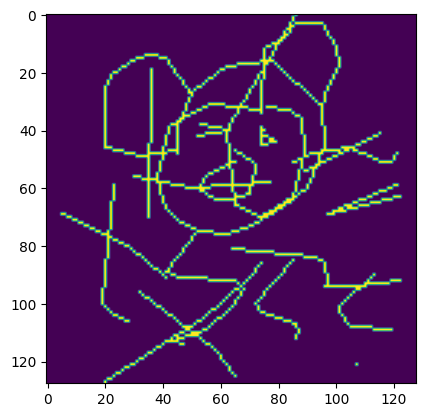

In [42]:
plt.imshow(train_ds[2][0].T)

In [43]:
# path = "data/jsondata"
# dir_list = os.listdir(path)
# splits = list(map(lambda x: os.path.splitext(x)[0],dir_list))
# labels = list(range(len(splits)))
# splits

In [44]:
import os, random, pickle, itertools, copy
import learn2learn as l2l
import torchvision as tv
from PIL.Image import LANCZOS
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels, ConsecutiveLabels
from learn2learn.vision.transforms import RandomClassRotation
from collections import defaultdict

/tmp/ipykernel_800003/3373575355.py:4: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from PIL.Image import LANCZOS


In [45]:
quickdraw = l2l.data.MetaDataset(train_ds)

In [62]:
batch_size = 10
num_epoch = 50
num_batch = 100
ways = 5
shots = 5
transforms_learn = [
    l2l.data.transforms.NWays(quickdraw, n=5),
    l2l.data.transforms.KShots(quickdraw, k=5*2),
    l2l.data.transforms.LoadData(quickdraw),
    l2l.data.transforms.RemapLabels(quickdraw),
    l2l.data.transforms.ConsecutiveLabels(quickdraw)
]
taskset = l2l.data.TaskDataset(dataset = quickdraw, task_transforms = transforms_learn, num_tasks=30000)
val_taskset = l2l.data.TaskDataset(dataset = valid_ds, task_transforms = transforms_learn, num_tasks=5000)
test_taskset = l2l.data.TaskDataset(dataset = test_ds, task_transforms = transforms_learn, num_tasks=5000)
# for task in taskset:
#     X, y = task

In [47]:
# from torch.utils.data import DataLoader
# from learn2learn.data import InfiniteIterator
# dataloader = DataLoader(taskset, shuffle=True, batch_size=batch_size)
# inf_dataloader = InfiniteIterator(dataloader)
# for iteration in range(num_batch):  # guaranteed to reach 10,000 regardless of len(dataloader)
#     X, y = next(inf_dataloader)
#     print(y)

In [48]:
def maml_init_(module):
    torch.nn.init.xavier_uniform_(module.weight.data, gain=1.0)
    torch.nn.init.constant_(module.bias.data, 0.0)
    return module
    
class ConvBlock(torch.nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 max_pool=True,
                 max_pool_factor=1.0):
        super(ConvBlock, self).__init__()
        stride = (int(2 * max_pool_factor), int(2 * max_pool_factor))
        if max_pool:
            self.max_pool = torch.nn.MaxPool2d(
                kernel_size=stride,
                stride=stride,
                # ceil_mode=False,
            )
            stride = (1, 1)
        else:
            self.max_pool = lambda x: x
        self.normalize = torch.nn.BatchNorm2d(
            out_channels,
            affine=True,
            # eps=1e-3,
            # momentum=0.999,
            # track_running_stats=False,
        )
        torch.nn.init.uniform_(self.normalize.weight)
        self.relu = torch.nn.ReLU()
        
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=1,
            bias=True,
        )
        maml_init_(self.conv)

    def forward(self, x):
        x = self.conv(x)
        x = self.normalize(x)
        x = self.relu(x)
        x = self.max_pool(x)

        return x

In [49]:
input_tensor = torch.randn(3,1,128,128)
conv_block = ConvBlock(1,32,3)
conv_block(input_tensor).shape

torch.Size([3, 32, 64, 64])

In [50]:
from collections import OrderedDict
class QuicDrawCNN(torch.nn.Module):
    def __init__(self,
                channels,
                out_features,
                hidden=64,
                max_pool=True,
                layers=4,
                max_pool_factor=1.0):
        super(QuicDrawCNN, self).__init__()
        self.in_channels = channels
        self.out_features = out_features
        self.hidden_size = hidden

        core = [('layer1',ConvBlock(channels,
                          hidden,
                          (3, 3),
                          max_pool=max_pool,
                          max_pool_factor=max_pool_factor),
                )]
        for i in range(layers - 1):
            core.append((f'layer{i+2}',ConvBlock(hidden,
                                  hidden,
                                  kernel_size=(3, 3),
                                  max_pool=max_pool,
                                  max_pool_factor=max_pool_factor)))
        self.features = torch.nn.Sequential(OrderedDict(core))
        # self.classifier = torch.nn.Linear(hidden*8*8, out_features, bias = True)
        # self.classifier.weight.data.normal_()
        # self.classifier.bias.data.mul_(0.0)

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        # features = features.view(features.size(0), -1)
        # logits = self.classifier(features)
        return features

In [51]:
model = QuicDrawCNN(1, 5, 64)
fast_lr = 0.005
lr = 0.0005
adaptation_steps = 5
# all_parameters = model.parameters()
# optimizer = torch.optim.Adam(all_parameters, lr=lr)
# model = l2l.algorithms.MAML(model, lr= fast_lr)
# loss = torch.nn.CrossEntropyLoss(reduction='mean')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# features = l2l.vision.models.ConvBase(hidden=64, channels=1, max_pool=True)
features = torch.nn.Sequential(model, l2l.nn.Lambda(lambda x: x.view(-1, 64*8*8)))
features.to(device)
head = torch.nn.Linear(64*8*8, ways)
head = l2l.algorithms.MAML(head, lr=fast_lr)
head.to(device)
all_parameters = list(features.parameters()) + list(head.parameters())
loss = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(all_parameters, lr=lr)



In [52]:
x,y = taskset.sample()

In [53]:
x = x.to(device)

In [54]:
def accuracy(predictions, query_labels):
    predictions = torch.argmax(predictions, dim = -1)
    num_data = predictions.size(0)
    true_predict = torch.sum(predictions == query_labels)
    return  true_predict/num_data

def fast_adapt(batch, learner,features, loss, adaptation_steps, shots,
               ways, device=None):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    data =  features(data)
    # Separate data into adaptation/evaluation sets
    support_indices = np.zeros(data.size(0), dtype=bool)
    support_indices[np.arange(shots*ways) * 2] = True
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    support_data, support_labels = data[support_indices], labels[support_indices]
    query_data, query_labels = data[query_indices], labels[query_indices]

    for step in range(adaptation_steps):
        train_error = loss(learner(support_data), support_labels)
        learner.adapt(train_error)

    predictions = learner(query_data)
    query_error = loss(predictions, query_labels)
    query_accuracy = accuracy(predictions, query_labels)
    return query_error, query_accuracy

In [63]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
name = '1'
writer = SummaryWriter(f'runs/{name}')
bar = tqdm(range(100000))
for iteration in bar:
    optimizer.zero_grad()
    meta_train_error = 0
    meta_train_accuracy = 0
    meta_valid_error = 0 
    meta_valid_accuracy = 0
    for task in range(batch_size):
        # Compute meta-training loss
        learner = head.clone()
        batch = taskset.sample()
        query_error, query_accuracy = fast_adapt(batch, learner,features, loss, adaptation_steps, shots, ways, device)
        query_error.backward()
        meta_train_error += query_error.item()
        meta_train_accuracy += query_accuracy.item()

        # Average the accumulated gradients and optimize
        for p in all_parameters:
            p.grad.data.mul_(1.0 / batch_size)
        optimizer.step()

        # Compute meta-validation loss
        learner = head.clone()
        batch = test_taskset.sample()
        query_error, query_accuracy = fast_adapt(batch,learner,features, loss, adaptation_steps, shots, ways, device)
        meta_valid_error += query_error.item()
        meta_valid_accuracy += query_accuracy.item()
        
    iter_error = meta_train_error/batch_size
    iter_acc = meta_train_accuracy/batch_size
    bar.set_postfix({'train loss': iter_error, 'train accuracy': iter_acc})
    writer.add_scalar('train loss', iter_error, iteration)
    writer.add_scalar('train accuracy', iter_acc, iteration)
    
meta_test_error = 0.0
meta_test_accuracy = 0.0
for task in range(batch_size):
    # Compute meta-testing loss
    learner = head.clone()
    batch = test_taskset.sample()
    query_error, query_accuracy = fast_adapt(batch,learner,features, loss, adaptation_steps, shots, ways, device)
    meta_test_error += query_error.item()
    meta_test_accuracy += query_accuracy.item()
print('Meta Test Error', meta_test_error / batch_size)
print('Meta Test Accuracy', meta_test_accuracy / batch_size)
    
        

  0%|          | 0/100000 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [71]:
writer.add_hparams(hparam_dict= {'ways':2, 'shots':2, 'sample':20}, metric_dict = {'test_loss': 1, 'test_acc': 2})

In [59]:
from learn2learn.data import partition_task

x, y = taskset.sample()
x, y = x.to(device), y.to(device)
x = features(x)
learner = head.clone()
(adapt_data, adapt_labels), (eval_data, eval_labels) = partition_task(x, y, shots=5)
train_error = loss(learner(adapt_data), adapt_labels)
learner.adapt(train_error)

In [61]:
learner.evaluate(eval_data)

AttributeError: 'Linear' object has no attribute 'evaluate'

To do
- Write result on tensorboard
- Run valid and test set
- Refactor to files and add parser
- Push to github
(Run with (5000 iter))